This notebook is an attempt to remove the class based object orientated structure of the functions in `ncomp.py` and turn it into a functional approach so that a more general energy surface model can be used without the need to embed it into the complex `state` object which is most useful for the multicomponent DWPM model, but less useful for general models. 

In general we will make it a lot less complex: no more phase detection, only one equilibrium point per feed point etc.

In [17]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from shgo import shgo  # !pip install shgo

In [18]:
# Test function from Mitsos
# Define parameters:
t_12 = 3.00498# tau paramters
t_21 = 4.69071
a_12 = 0.391965 # Alpha paramter
a_21 = 0.391965#**(-1.0) # Checked. Should be a_12 in Mitsos, see SvA p 448
p = [t_12, t_21, a_12, a_21]

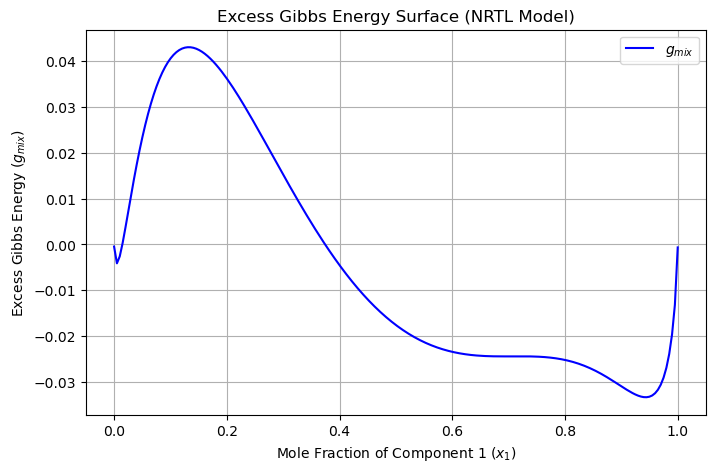

In [19]:

# Parameters for the NRTL equation
t_12 = 3.00498  # Tau parameter
t_21 = 4.69071
a_12 = 0.391965  # Alpha parameter
a_21 = a_12 #1.0 / a_12  # Should _normally_ be reciprocal of a_12, but not in this 2007 Mitsos paper

# Parameter vector
p = [t_12, t_21, a_12, a_21]

def g_nrtl(x, p):
    """
    Computes the Gibbs excess energy for a binary mixture using the NRTL model.

    The NRTL (Non-Random Two-Liquid) equation is used to calculate the excess 
    Gibbs free energy in non-ideal mixtures.

    Parameters
    ----------
    x : list or array_like
        Mole fractions of component 1 and component 2, [x1, x2], where x2 = 1 - x1.
    p : list or tuple
        Model parameters [tau_12, tau_21, alpha_12, alpha_21].

    Returns
    -------
    float
        Excess Gibbs free energy (dimensionless).

    Notes
    -----
    The NRTL model is defined as:

        g_mix = x1 * ln(x1) + x2 * ln(x2) + x1 * x2 * (
                (tau_12 * exp(-alpha_12 * tau_12)) / (x2 + x1 * exp(-alpha_12 * tau_12))
              + (tau_21 * exp(-alpha_21 * tau_21)) / (x1 + x2 * exp(-alpha_21 * tau_21)))

    where:
    - x1, x2: Mole fractions of components 1 and 2 (x2 = 1 - x1).
    - tau_12, tau_21: Interaction parameters.
    - alpha_12, alpha_21: Non-randomness parameters.
    """
    t_12, t_21, a_12, a_21 = p
    x1, x2 = x[0], x[1]
    
    g_mix = (x1 * np.log(x1)
             + x2 * np.log(x2)
             + x1 * x2
             * ((t_12 * np.exp(-a_12 * t_12)) / (x2 + x1 * np.exp(-a_12 * t_12))
                + (t_21 * np.exp(-a_21 * t_21)) / (x1 + x2 * np.exp(-a_21 * t_21))))
    
    return g_mix


def plot_g_nrtl(p):
    """
    Plots the excess Gibbs energy (g_mix) as a function of mole fraction x1.

    Parameters
    ----------
    p : list or tuple
        Model parameters [tau_12, tau_21, alpha_12, alpha_21].
    """
    x1_vals = np.linspace(0.0001, 0.9999, 200)  # Avoid log(0) issues
    x2_vals = 1 - x1_vals
    g_vals = [g_nrtl([x1, x2], p) for x1, x2 in zip(x1_vals, x2_vals)]

    plt.figure(figsize=(8, 5))
    plt.plot(x1_vals, g_vals, label=r'$g_{mix}$', color='b')
    plt.xlabel(r'Mole Fraction of Component 1 ($x_1$)')
    plt.ylabel(r'Excess Gibbs Energy ($g_{mix}$)')
    plt.title('Excess Gibbs Energy Surface (NRTL Model)')
    plt.legend()
    plt.grid()
    plt.show()


# Example usage
plot_g_nrtl(p)


In [20]:
g_nrtl([0.5, 0.5], p)

np.float64(-0.017577543275037022)

### New implementation using while loop minimization plus plots 

In [21]:
# %% Duality formulation
def ubd(X_D, Z_0, g_x_func, s, p, k=None):
    """
    Returns the arguments to be used in the optimisation of the upper bounding
    problem with scipy.optimize.linprog.

    used
    Parameters
    ----------
    X_D : vector (1xn array)
          Contains the current composition point in the overall dual
          optimisation. Constant for the upper bounding problem.

    Z_0 : vector (1xn array)
          Feed composition. Constant.

    g_x_func : function
               Returns the gibbs energy at a the current composition
               point. Should accept s, p as first two arguments.
               Returns a class containing scalar value .m['g_mix']['t']

    s : class
        Contains the dictionaries with the system state information.
        NOTE: Must be updated to system state at P, T, {x}, {y}...

    p : class
        Contains the dictionary describing the parameters.

    k : list, optional (TODO)
        List contain valid phases for the current equilibrium calculation.
        ex. k = ['x', 'y']
        If default value None is the value in p.m['Valid phases'] is retained.

    Returns
    -------
    c : array_like
        Coefficients of the linear objective function to be minimized.

    A : A_eq : array_like, optional
        2-D array which, when matrix-multiplied by x, gives the values of the
        upper-bound inequality constraints at x.

    b : array_like, optional
        1-D array of values representing the upper-bound of each inequality
        constraint (row) in.
    """
    import numpy
    # Coefficients of UBD linear objective function
    c = numpy.zeros([p.m['n']]) # linrpog maximize/minimize? D
                 # Documentation is contradictory across version; check
    c[p.m['n'] - 1] = -1.0  # -1.0 change max --> min problem

    # Coefficients of Lambda inequality constraints

    A = numpy.zeros([len(X_D) + 1, # rows = for all X_D + Global ineq
                     p.m['n']]     # cols = n comps + eta
                    )
    b = numpy.zeros(len(X_D) + 1)


    # Global problem bound (Fill last row of A and last element in b
    # G_p (Primal problem Z_0_i - x_i = 0 for all i)
    # TODO: Move outside function and outside loop in dual
    s = s.update_state(s, p, X = Z_0, Force_Update=True)
    G_P = g_x_func(s, p).m['g_mix']['t']
    A[len(X_D), p.m['n'] - 1] = 1  # set eta to 1
    b[len(X_D)] = G_P

    # Bounds for all X_d in X_D
    A[:, p.m['n'] - 1] = 1  # set all eta coefficients = 1
    for X, k in zip(X_D, range(len(X_D))):
        # Find G(X_d)
        s = s.update_state(s, p, X = X, Force_Update=True)
        #TODO: This only needs to be evaluated once for every x \in X^D
        G_d = g_x_func(s, p).m['g_mix']['t']
        b[k] = G_d
        for i in range(p.m['n'] - 1):
            A[k, i] = -(Z_0[i] - X_D[k][i])

    if False:
        print('c shape = {}'.format(numpy.shape(c)))
        print('A shape = {}'.format(numpy.shape(A)))
        print('b shape = {}'.format(numpy.shape(b)))
        print('c = {}'.format(c))
        print('A = {}'.format(A))
        print('b = {}'.format(b))

    return c, A, b

def lbd(X, g_x_func, Lambda_d, Z_0, s, p, k=['All']):
    """
    Returns the lower bounding problem of the dual extremum.
    
    Parameters
    ----------
    X : vector (1xn array)
        Contains the current composition point in the overall dual
        optimisation to be optimised to the minimum value of the lbd.

    g_x_func : function
               Returns the gibbs energy at a the current composition 
               point. Should accept s, p as first two arguments.
               Returns a class containing scalar value .m['g_mix']['t']
                        
    Lambda_d : vector (1xn array)
               Contains the diality multipliers Lambda \in R^m.
               Constant for the lower bounding problem.
             
    Z_0 : vector (1xn array)
          Feed composition. Constant.
    
    s : class
        Contains the dictionaries with the system state information.
        NOTE: Must be updated to system state at P, T, {x}, {y}...
    
    p : class
        Contains the dictionary describing the parameters.
        
    k : list, optional
        List contain valid phases for the current equilibrium calculation.
        ex. k = ['x', 'y']
        If default value None is the value in p.m['Valid phases'] is retained.  
        
    Dependencies
    ------------
    numpy.array
    math.e

    Returns
    -------
    lbd : scalar
          Value of the lower bounding problem at X.
    """
    # Update system to new composition.
    s.update_state(s, p,  X = X, phase=k, Force_Update=True)

    return g_x_func(s, p).m['g_mix']['t'] + sum(Lambda_d * (Z_0 - X))
   
def dual_equal(s, p, g_x_func, Z_0, k=None, P=None, T=None, tol=1e-9, n=100):
    """
    Dev notes and TODO list
    -----------------------
    TODO: -The material bounds is too high since (Mitsos')  \hat{X} is the true
            upper limit for a given feedpoint
          -Look into using X_bounds scheme of Pereira instead for low mole Z_0
          -Add valid phases option.
          -Add constraints to x_i =/= 0 or 1 for all i to prevent vertical
            hyperplanes.
          -Construct bounds which is a list of tuples in [0,1] \in R^n

    NOTES: -Strictly the composition in all phases in should be specified in
            X_d, refer to older versions of this script when different comp.
            spaces need to be used.
    -----------------------
    Find the phase equilibrium solution using the daul optimization algorithm.
    Ref. Mitsos and Barton (2007)
    
    Parameters
    ----------
    s : class
        Contains the dictionaries with the system state information.
        NOTE: Must be updated to system state at P, T, {x}, {y}...
    
    p : class
        Contains the dictionary describing the parameters.

    g_x_func : function
               Returns the gibbs energy at a the current composition 
               point. Should accept s, p as first two arguments.
               Returns a class containing scalar value .m['g_mix']['t']

    k : list, optional
        List contain valid phases for the current equilibrium calculation.
        ex. k = ['x', 'y']
        If default value None is the value in p.m['Valid phases'] is retained.  

    P : scalar, optional
        Pressure (Pa), if unspecified the current state pressure will be used.

    T : scalar, optional
        Temperature (K), if unspecified  the current state temperature will be 
        used.

    Z_0 : vector
          Contains the feed composition point (must be and unstable point to 
          find multiphase equilibria).
          
    tol : scalar, optional
          Tolerance, if epsilon >= UBD - LBD that will terminate the routine.

    n : scalar, optional
        Number of sampling points used in the tgo routine in solving LBD of the
        dual problem.
        Note: It is recommended to use at least ``100 + p.m['n'] * 100``
          
    Dependencies
    ------------
    numpy

    Returns
    -------
    X_sol : vector
            Contains the first optimised equilibrium point of the dual problem

    Lambda_sol : vector
                 Contains the optimised lagrange multipliers (partial chemical
                 potential) sol. of the dual solution hyperplane

    d_res : optimisation object return
            Contains the final solution to the dual problem with the
            following values:
                d_res.fun : lbd plane solution at equil point
                d_res.xl : Other local composition solutions from final tgo
                d_res.funl : lbd plane at local composition solutions

    """
    import numpy
    from scipy.optimize import linprog
    from tgo import tgo

    def x_lim(X): # limiting function used in TGO defining material constraints
        import numpy
        #return -numpy.sum(X, axis=-1) + 1.0
        return -numpy.sum(X, axis=0) + 1.0

    if k is None:
        k = p.m['Valid phases']
        
    # Initialize
    Z_0 = numpy.array(Z_0)
    LBD = - 1e300  # -inf
    s.update_state(s, p,  X = Z_0, phase = k, Force_Update=True) 
        
    # G_p (Primal problem Z_0_i - x_i = 0 for all i):
    UBD = g_x_func(s, p).m['g_mix']['t']

    # X bounds used in UBD optimization
    X_bounds = [[],  # Upper bound (bar x)
                []   # Lower bound (hat x)
                ]

    for i in range(p.m['n']-1):
        # Append an independent coordinate point for each bound
        X_bounds[0].append(numpy.zeros(shape=(p.m['n']-1)))
        X_bounds[1].append(numpy.zeros(shape=(p.m['n']-1)))

        # Set upper bound coordinate point i
        Sigma_ind = 0.0  # Sum of independent components excluding i
                         # (lever rule)
        for k_ind in range(p.m['n']-1): # Note: k var name is used as phase
            # Set k != i  (k==i changed at end of loop)
            X_bounds[0][i][k_ind] = Z_0[k_ind]
            if k_ind != i:
                Sigma_ind += Z_0[k_ind] # Test, use numpy.sum if working

                # Set Lower bound coordinate point i
                X_bounds[1][i][k_ind] = Z_0[k_ind]
                # (Remaining bound coordinate points kept at zero)

        X_bounds[0][i][i] = 1.0 - Sigma_ind # change from Z_0[k]

    # Construct physical bounds x \in [0, 1] for all independent components
    Bounds = []
    L_bounds = [] # Lambda inf bounds used in linprog.
    for i in range(p.m['n'] - 1):
        Bounds.append((1e-10, 0.99999999))
        L_bounds.append((-numpy.inf, numpy.inf))

    L_bounds.append((-numpy.inf, numpy.inf)) # Append extra bound set for eta

    # Update state to random X to initialise state class.
    X_sol = numpy.array(X_bounds[1][0])  # set X_sol to lower bounds
    s.update_state(s, p,  X = X_sol , phase = k, Force_Update=True)

    X_D = []  # set empty list
    # Add every X_bounds to X_D list to use in linprog
    for i in range(p.m['n']-1):
        X_D.append(X_bounds[0][i])
        X_D.append(X_bounds[1][i])


    if True:  # Lambda estimates using differentials at Z_0
        # NOTE on CO2-ethane test this cut the iterations down to 6 from 9
        Lambda_d = numpy.zeros_like(Z_0)
        s.update_state(s, p, X=Z_0, phase=k, Force_Update=True)
        for z in range(1, p.m['n']):
            Lambda_d[z - 1] = FD(g_mix, s, p, d=1, z=z, gmix=True)
            #print('Lambda_d from init FD est. = {}'.format(Lambda_d))

        # Solve LBD for first cutting plane
        d_res = tgo(lbd, Bounds, args=(g_x_func, Lambda_d, Z_0, s, p, k),
                    g_cons=x_lim,
                    n=n,
                    #k_t=2,
                    # n = 100 + 100*(p.m['n'] - 1),
                    )  # skip=2)

        X_sol = d_res.x
        X_D.append(X_sol)
        #print('X_sol from init FD est. = {}'.format(X_sol))
        if len(d_res.xl) > 0:
            for i in range(len(d_res.xl)):
                #print('d_res.xl{}'
                #      ' from init FD est. = {}'.format(i, d_res.xl[i]))
                X_D.append(d_res.xl[i])

       # print('X_D at init = {}'.format(X_D))

    #%% Normal calculation of daul problem if Z_0 is unstable.
    iteration = 0
    #X_D.append(numpy.array([ 0.19390632]))
    while abs(UBD - LBD) >= tol:
        iteration +=1
        # Solve UBD
        # Find new bounds for linprog
        c, A, b = ubd(X_D, Z_0, g_x_func, s, p)
        # Find mulitpliers with max problem.
        lp_sol = linprog(c, A_ub=A, b_ub=b, bounds=L_bounds)
        Lambda_sol = numpy.delete(lp_sol.x, numpy.shape(lp_sol.x)[0] - 1)
        # If float convert back to 1x1 array
        Lambda_sol = numpy.array(Lambda_sol)

        UBD = -lp_sol.fun  # Final func value is neg. of minimised max. problem

        # dual stepping plots
        if 0:
            print('Iteration number: {}'.format(iteration))
            #print('Lambda_sol: {}'.format(Lambda_sol))
            print('X_sol: {}'.format(X_sol))
            print('X_D: {}'.format(X_D))
            x_r = 1000
            # Lagrange function surface
            plane_args = (Lambda_sol, Z_0, g_x_func, s, p, ['All'])
            plot.plot_ep(dual_lagrange, x_r, s, p, args=plane_args)

            # Dual plane
            if p.m['n'] == 2:
                s.update_state(s, p, X=X_sol[0], Force_Update=True)
                G_sol = g_x_func(s, p).m['g_mix']['t']
                print('G_sol : {}'.format(G_sol))
                plot.plot_g_mix(s, p, g_x_func, Tie=[[Z_0, X_sol]], x_r=1000,
                                plane_func=dual_plane_sol,
                               # plan_args=(G_sol, -Lambda_sol, Z_0, X_sol))
                                plan_args=(G_sol, Lambda_sol, Z_0, X_sol))


        # Solve LBD
        d_res = tgo(lbd, Bounds, args=(g_x_func, Lambda_sol, Z_0, s, p, k),
                                 g_cons=x_lim,
                                 n = n,
                                 #n = 100 + 100*(p.m['n'] - 1),
                    )#skip=2)

        X_sol = d_res.x
        X_D.append(X_sol)

        #if True:  # NOTE: Reduced iterations from 6 to 3 !
        if False:
            if len(d_res.xl) > 0:
                for i in range(len(d_res.xl)):
                    #print('X_D = {}'.format(X_D))
                    #print('d_res.xl) = {}'.format(d_res.xl))
                    X_D.append(d_res.xl[i])

        # Calculate LBD
        LBD = lbd(X_sol, g_x_func, Lambda_sol, Z_0, s, p, k)
        # End if tol

        if True:  # dual stepping plots
            print('Iteration number: {}'.format(iteration))
            #print('Lambda_sol: {}'.format(Lambda_sol))
            #print('X_sol: {}'.format(X_sol))
            print('X_D: {}'.format(X_D))
            x_r = 1000
            # Lagrange function surface
            #plane_args = (Lambda_sol, Z_0, g_x_func, s, p, ['All'])
            #plot.plot_ep(dual_plane, x_r, s, p, args=plane_args)

            # Dual plane
            if p.m['n'] == 2:
                s.update_state(s, p, X=X_sol[0], Force_Update=True)
                G_sol = g_x_func(s, p).m['g_mix']['t']
                print('G_sol: {}'.format(G_sol))
                plot.plot_g_mix(s, p, g_x_func, Tie=[[Z_0, X_sol]] , x_r=1000,
                                plane_func=dual_plane_sol,
                                #plan_args=(G_sol, -Lambda_sol, Z_0, X_sol))
                                plan_args=(G_sol, Lambda_sol, Z_0, X_sol))


    if False:  # Print results optional
        print('Final UBD = {}'.format(UBD))
        print('Final LBD = {}'.format(LBD))
        print('Final UBD - LBD = {}'.format(UBD - LBD))
        print('Final Z_eq = {}'.format(X_sol))
        print('Final Lambda_d = {}'.format(Lambda_d))

    if False:  # Feed point plane estimate dev
        x_r = 1000
        # Suppose data_solutions at
        # [[array([ 0.1939063]), array([ 0.30898849])]]
        X_I = numpy.array([ 0.1939063])
        s.update_state(s, p, X=X_I, Force_Update=True)
        G_sol_I = g_x_func(s, p).m['g_mix']['t']
        X_II = numpy.array([ 0.30898849])
        s.update_state(s, p, X=X_II, Force_Update=True)
        G_sol_II = g_x_func(s, p).m['g_mix']['t']
        print(' G_sol_I = {}'.format(G_sol_I))
        print(' G_sol_II = {}'.format(G_sol_II))
        # Plane estimates
        # (NOTE: These lambda estimates need to be done for each component
        # in higher dimensions)
        Lambda_sol_est = (G_sol_II - G_sol_I)/ (X_II - X_I)
        Z_0 = (X_I + X_II)/2.0  # (Estimate of feed point)
        plot.plot_g_mix(s, p, g_x_func, Tie=[[Z_0, X_sol]], x_r=1000,
                        plane_func=dual_plane_sol,
                        plan_args=(G_sol_I, Lambda_sol_est, X_II, X_I)
                        #plan_args=(G_sol_I, Lambda_sol_est, Z_0, X_I)
                        )
    # Returns
    return X_sol, Lambda_sol, d_res

#### Latest code using while loop

In [22]:
import numpy as np
from scipy.optimize import linprog

###############################################################################
# 1) LOWER BOUND EVALUATION
###############################################################################
def lbd(x, g_func, Lambda, Z_0):
    """
    Evaluate the lower-bounding function for the dual problem.

    Parameters
    ----------
    x : 1D array_like
        Current composition (length n). Must satisfy sum(x) = 1, x >= 0.
    g_func : callable
        A Gibbs free energy function G(x) that returns a scalar.
    Lambda : 1D array_like
        Lagrange multipliers (length n) from the upper bounding step.
    Z_0 : 1D array_like
        Feed composition (length n) with sum(Z_0) = 1.

    Returns
    -------
    float
        Value of G(x) + Lambda dot (Z_0 - x).
    """
    return g_func(x) + np.dot(Lambda, (Z_0 - x))


###############################################################################
# 2) UPPER BOUND CONSTRUCTION
###############################################################################
def ubd(X_D, Z_0, g_func, n):
    """
    Builds the linear program (LP) used to find the new dual hyperplane.

    This sets up a max-η subject to:
       η <= G(x_d) + Lambda^T (Z_0 - x_d)   for all x_d in X_D
       η <= G(Z_0)                         (optional global bound)
    and Lambda is unconstrained except possibly by numeric bounds
    to keep the LP well-defined.

    Parameters
    ----------
    X_D : list of 1D array_like
        List of compositions (length n each). These points have been found
        so far in the dual iterations.
    Z_0 : 1D array_like
        Feed composition (length n).
    g_func : callable
        Gibbs free energy function G(x).
    n : int
        Number of components (length of x).

    Returns
    -------
    c : ndarray
        Coefficients of the linear objective for `linprog`.
    A_ub : ndarray
        Matrix of inequality constraints for `linprog`.
    b_ub : ndarray
        RHS vector of inequality constraints for `linprog`.
    bounds : list of tuples
        Bounds for the decision variables [Lambda_1, ..., Lambda_n, eta].
        Each bound is a tuple (lb, ub). Usually (-np.inf, np.inf) for Lambdas.
    """
    # We'll store variables in this order: [Lambda_1, ..., Lambda_n, eta]
    # So the dimension is n + 1 total decision variables.
    # We want to maximize eta => in standard linprog form, we "minimize -eta".
    c = np.zeros(n + 1)
    c[-1] = -1.0  # Minimizing -eta is same as maximizing eta

    # Build constraints:
    # For each x_d in X_D:  eta <= G(x_d) + Lambda^T (Z_0 - x_d)
    # =>  -eta + Lambda^T (Z_0 - x_d) <= G(x_d)
    # =>  (Z_0 - x_d) for Lambda part, -1 for eta part.

    num_points = len(X_D)
    A_ub = np.zeros((num_points + 1, n + 1))
    b_ub = np.zeros(num_points + 1)

    # Optional global constraint: eta <= G(Z_0)
    G_feed = g_func(Z_0)  # We can use the feed composition's own G
    A_ub[num_points, -1] = -1.0
    b_ub[num_points] = G_feed

    # Constraints from each x_d
    for k, x_d in enumerate(X_D):
        # Coeff for Lambda part is (Z_0 - x_d)
        for i in range(n):
            A_ub[k, i] = Z_0[i] - x_d[i]
        # Coeff for eta part is -1
        A_ub[k, -1] = -1.0
        # RHS is G(x_d)
        b_ub[k] = g_func(x_d)

    # Bounds on Lambda_i can be unbounded
    # Bounds on eta can also be unbounded above (in principle).
    # But typically you might impose practical bounds on Lambdas to help numerical stability.
    # For this example, let's just leave them unbounded:
    bounds = [(-1.0e9, 1.0e9)]*(n+1)

    return c, A_ub, b_ub, bounds


###############################################################################
# 3) MAIN DUAL-BASED SOLVER
###############################################################################
def solve_dual_equilibrium(g_func, Z_0, n,
                           tol=1e-9,
                           max_iter=20,
                           global_minimizer=None):
    """
    Solves for a dual hyperplane that proves the system is unstable
    at Z_0 (or identifies that single-phase is stable if no feasible
    cutting plane can be found). The user must supply a global minimizer
    for the LBD step.

    Parameters
    ----------
    g_func : callable
        A function g_func(x) -> float that returns the Gibbs free energy.
        x is an array of length n with sum(x) = 1, x[i] >= 0.
    Z_0 : 1D array_like
        Feed composition of length n, sum(Z_0)=1.
    n : int
        Number of components in the mixture.
    tol : float, optional
        Convergence tolerance. If UBD - LBD < tol, iteration stops.
    max_iter : int, optional
        Maximum number of dual iterations.
    global_minimizer : callable or None
        A user-provided global optimizer for the LBD subproblem.
        Must have signature:  global_minimizer(obj_func, n, args, x_bounds)
        and return (x_star, obj_star). If None, we provide a placeholder.

    Returns
    -------
    X_sol : 1D array
        Composition that yields the best cutting plane in the final iteration.
    Lambda_sol : 1D array
        Final Lagrange multipliers for the dual tangent plane.
    history : dict
        Diagnostic info about iteration progress.

    Notes
    -----
    - The code is purely functional, with no references to temperature or pressure.
    - Phase detection is replaced by direct bounding-plane construction.
    - If single-phase is indeed stable, you might find that the linear program
      basically saturates at the feed composition with no beneficial cut,
      i.e. LBD and UBD remain near G(Z_0).

    Example usage:
        def my_global_minimizer(obj_func, n, args, x_bounds):
            # do some global search
            return (best_x, best_val)

        X_sol, Lambda_sol, hist = solve_dual_equilibrium(
            g_nrtl, [0.5, 0.5], n=2, global_minimizer=my_global_minimizer
        )
    """
    Z_0 = np.array(Z_0, dtype=float)
    assert abs(Z_0.sum() - 1.0) < 1e-12, "Z_0 must sum to 1"
    assert all(Z_0 >= 0), "All feed composition entries must be >= 0"

    # For convenience, define a trivial initial set X_D with
    # "corner" points to help bound multipliers:
    # e.g. slightly perturbed pure corners & feed itself, etc.
    # We'll also store the feed composition in X_D so we get the
    # global bound from G(Z_0).
    X_D = []
    eps = 1e-8

    # Add points that are "almost pure" in each component
    for i in range(n):
        x_pure = np.zeros(n, dtype=float)
        x_pure[i] = 1.0
        X_D.append(0.9999999 * x_pure + 1e-8)  # small shift
        # Also a slightly "near-zero" composition:
        x_low = np.full(n, 1.0/(n*1.0))
        x_low[i] = eps
        x_low[(i+1) % n] = 1 - eps - (n-1)*(1/(n*1.0))
        X_D.append(x_low)

    # Finally add the feed composition itself
    X_D.append(Z_0)

    # Evaluate initial LBD & UBD
    LBD = -1e15  # something like negative infinity
    UBD = g_func(Z_0)  # trivial upper bound from feed

    history = {
        'iterations': [],
        'UBD': [],
        'LBD': [],
        'Lambda': [],
        'X_star': []
    }

    def default_global_minimizer(obj_func, n, args, x_bounds):
        """
        Placeholder local/naive approach for demonstration:
        random sampling + local check. Not truly global.
        """
        best_val = 1e15
        best_x = None
        n_samples = 200

        for _ in range(n_samples):
            # sample random composition x, sum=1
            xr = np.random.rand(n)
            xr = xr / xr.sum()
            val = obj_func(xr, *args)
            if val < best_val:
                best_val = val
                best_x = xr

        return best_x, best_val

    if global_minimizer is None:
        global_minimizer = default_global_minimizer

    for iteration in range(1, max_iter+1):

        # Step 1: Solve UBD as an LP
        c, A_ub, b_ub, bounds = ubd(X_D, Z_0, g_func, n)
        lp_res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
        if not lp_res.success:
            # If LP fails, we stop. Possibly single-phase stable or numeric issues
            print("LP failed at iteration", iteration, lp_res.message)
            break

        # Decision variables are [Lambda_1..Lambda_n, eta]
        x_lp = lp_res.x
        Lambda_sol = x_lp[:n].copy()
        eta_sol = x_lp[-1]

        # Because c[-1] = -1, we minimized -eta => final objective is -eta_sol
        # => UBD =  -lp_res.fun
        cur_UBD = -lp_res.fun

        # Step 2: Solve LBD subproblem via global minimization
        #   lbd(x) = G(x) + sum( Lambda_sol * (Z_0 - x) )
        # We'll define a small wrapper:
        def lbd_obj(x, g_func, Lambda, Z_0):
            return lbd(x, g_func, Lambda, Z_0)

        x_star, val_star = global_minimizer(lbd_obj, n, (g_func, Lambda_sol, Z_0), None)
        cur_LBD = val_star

        # Update iteration tracking
        history['iterations'].append(iteration)
        history['UBD'].append(cur_UBD)
        history['LBD'].append(cur_LBD)
        history['Lambda'].append(Lambda_sol)
        history['X_star'].append(x_star)

        # If improvement was found, add x_star to X_D
        X_D.append(x_star)

        # Check termination
        if abs(cur_UBD - cur_LBD) < tol:
            print(f"Converged at iteration {iteration} with UBD={cur_UBD:.6g}, "
                  f"LBD={cur_LBD:.6g}")
            break

        # Prepare for next iteration
        LBD = cur_LBD
        UBD = cur_UBD

    # Return the final results
    return x_star, Lambda_sol, history



In [23]:
def g(x):
    return g_nrtl(x, p)

x_star, Lambda_sol, history = solve_dual_equilibrium(g, [0.5, 0.5], 2,
                           tol=1e-9,
                           max_iter=20,
                           global_minimizer=None)

In [24]:
x_star

array([0.94166716, 0.05833284])

In [25]:
if __name__ == "__main__":
    # Suppose we define a simple binary Gibbs function:
    def g_nrtl_example(x):
        """
        Example binary NRTL-like G(x) for x of length 2, x[0] + x[1] = 1.
        Hard-coded parameters for demonstration.
        """
        # x[1] = 1 - x[0], so let's rename x1 = x[0], x2 = 1 - x[0].
        x1 = x[0]
        x2 = x[1]
        # Just a toy function or real NRTL if you'd like:
        import math
        t12, t21 = 3.0, 4.69
        a12, a21 = 0.39, 0.39
        # Ideal + NRTL terms:
        if x1 < 1e-14 or x2 < 1e-14:
            return 0.0  # or a big penalty if purely 0
        val = (x1*math.log(x1) + x2*math.log(x2) +
               x1*x2 * ((t12*math.exp(-a12*t12)) / (x2 + x1*math.exp(-a12*t12))
                        + (t21*math.exp(-a21*t21)) / (x1 + x2*math.exp(-a21*t21))))
        return val

    # Two-component feed, 50-50
    Z0 = [0.3, 0.7]
    # We call solve_dual_equilibrium with a user-chosen global_minimizer (or let the default run).
    x_sol, Lambda_sol, hist = solve_dual_equilibrium(
        g_func=g_nrtl_example,
        Z_0=Z0,
        n=2,
        tol=1e-7,
        max_iter=10
    )

    print("----- Dual solution results -----")
    print("x_sol =", x_sol)
    print("Lambda_sol =", Lambda_sol)
    print("UBD history =", hist['UBD'])
    print("LBD history =", hist['LBD'])


----- Dual solution results -----
x_sol = [0.99574938 0.00425062]
Lambda_sol = [ 1.e+09 -1.e+09]
UBD history = [1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0]
LBD history = [np.float64(-1363895985.9512262), np.float64(-1351684670.3704748), np.float64(-1379717620.7802632), np.float64(-1370695048.4740674), np.float64(-1388625933.2379339), np.float64(-1393694966.2077305), np.float64(-1385511694.093428), np.float64(-1391424238.5770748), np.float64(-1396750223.7178998), np.float64(-1391498755.2764492)]


#### Test on polynomial

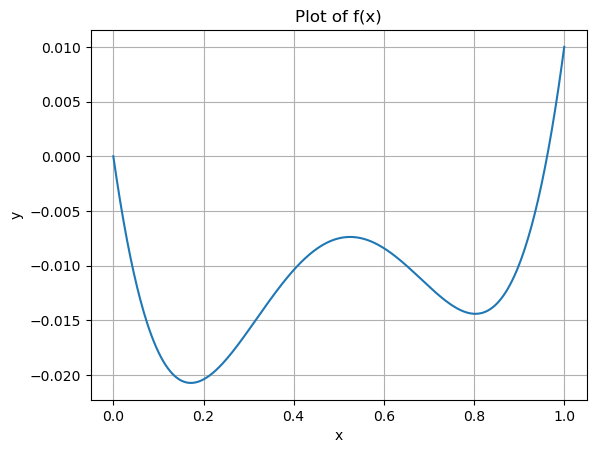

In [26]:
def f(x):
    #return 0.01*x + (x - 0.5)**4 - 0.2 * (x - 0.5)**2 -0.0125#- 0.3125
    return 0.01* x+ (x - 0.5)**4 - 0.2 * (x - 0.5)**2 -0.0125#- 0.3125

def f_2d(x):
    #return 0.01*x + (x - 0.5)**4 - 0.2 * (x - 0.5)**2 -0.0125#- 0.3125
    return 0.01*x[0] + (x[0] - 0.5)**4 - 0.2 * (x[0] - 0.5)**2 -0.0125#- 0.3125
# Plotting
if 1:
    # Values
    x = np.linspace(0, 1, 400)
    y = f(x)

    # plot f(x)
    plt.figure()
    plt.plot(x, y)
    plt.title('Plot of f(x)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

In [27]:
# Two-component feed, 50-50
Z0 = [0.5, 0.5]
# We call solve_dual_equilibrium with a user-chosen global_minimizer (or let the default run).
x_sol, Lambda_sol, hist = solve_dual_equilibrium(
    g_func=f_2d,
    Z_0=Z0,
    n=2,
    tol=1e-7,
    max_iter=10
)

print("----- Dual solution results -----")
print("x_sol =", x_sol)
print("Lambda_sol =", Lambda_sol)
print("UBD history =", hist['UBD'])
print("LBD history =", hist['LBD'])

----- Dual solution results -----
x_sol = [0.1721357 0.8278643]
Lambda_sol = [-1.e+09 -1.e+09]
UBD history = [1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0]
LBD history = [np.float64(-0.020721972924844085), np.float64(-0.02071304285432262), np.float64(-0.02072190965197148), np.float64(-0.020717680445219565), np.float64(-0.020703864946316996), np.float64(-0.02071154152455217), np.float64(-0.020722385656869992), np.float64(-0.02067875426537613), np.float64(-0.020716223522011183), np.float64(-0.020722467986219236)]


#### New plots

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

def plot_g_binary(
    g_func,
    x_min=1e-4,
    x_max=1 - 1e-4,
    num_points=200,
    eq_points=None,
    # Default colors:
    color_surface=(1.0, 0.498, 0.0),  # Approx "tab:orange"
    color_planes=(0.1216, 0.4667, 0.7059),  # Approx "tab:blue"
    color_vertical=(0.5, 0.5, 0.5)         # Gray for vertical lines
):
    """
    Plots a one-dimensional Gibbs free energy function G(x) for a binary mixture,
    with optional equilibrium highlights.

    Parameters
    ----------
    g_func : callable
        A Gibbs free energy function of one variable, G(x),
        with domain x in (0,1).
    x_min : float, optional
        Minimum x-value for plotting (to avoid singularities at x=0).
    x_max : float, optional
        Maximum x-value for plotting (to avoid singularities at x=1).
    num_points : int, optional
        Number of points in the plotting grid from x_min to x_max.
    eq_points : list or tuple of floats, optional
        Typically two solution points [x_alpha, x_beta] for an equilibrium split.
        If provided:
          - Draws gray dashed vertical lines at each solution
          - Attempts to label them below the x-axis as x^α, x^β
          - Draws the chord (straight line) between (x_alpha, G(x_alpha)) and
            (x_beta, G(x_beta)) both across the entire domain and restricted to
            the interval [x_alpha, x_beta].
    color_surface : tuple of 3 floats
        RGB color for the G(x) surface curve. Default is approximately tab:orange.
    color_planes : tuple of 3 floats
        RGB color for the chords. Default is approximately tab:blue.
    color_vertical : tuple of 3 floats
        RGB color for the vertical lines. Default is gray.

    Returns
    -------
    None
        Displays a matplotlib figure.

    Example
    -------
    >>> def example_g(x):
    ...     # simple polynomial curve
    ...     return 0.01*x + (x-0.5)**4 - 0.2*(x-0.5)**2
    >>> plot_g_binary(example_g, eq_points=[0.2, 0.8])
    """
    x_vals = np.linspace(x_min, x_max, num_points)
    g_vals = [g_func(x) for x in x_vals]

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, g_vals, color=color_surface, label='G(x)')

    plt.xlabel('Mole Fraction of Component 1, x')
    plt.ylabel('Gibbs Free Energy, G(x)')
    plt.title('Binary Gibbs Free Energy')
    plt.grid(True)

    # If eq_points provided (often two), mark them
    if eq_points is not None and len(eq_points) > 0:
        # Sort for consistent left->right
        eq_points_sorted = sorted(eq_points)

        # Vertical lines & chord(s)
        for i, x_star in enumerate(eq_points_sorted):
            # Draw a dashed vertical line
            plt.axvline(x_star, color=color_vertical, linestyle='--', alpha=0.8)

            # Attempt to label below the x-axis
            # If too clipped in your environment, remove or adjust the offset
            label_text = r"$x^{\alpha}$" if i == 0 else r"$x^{\beta}$"
            # We'll place the annotation at (x_star, 'bottom of axes'):
            ax = plt.gca()
            trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
            plt.annotate(
                label_text,
                xy=(x_star, 0),  # x in data coords, y=0 in axes coords
                xycoords=trans,
                xytext=(0, -25),  # shift downward by 25 points
                textcoords='offset points',
                ha='center',
                va='top',
                color=color_vertical,
                annotation_clip=False  # allow drawing outside axes
            )

        # If we have at least two points, draw the chord
        if len(eq_points_sorted) >= 2:
            x_alpha = eq_points_sorted[0]
            x_beta = eq_points_sorted[1]
            G_alpha = g_func(x_alpha)
            G_beta = g_func(x_beta)

            if abs(x_beta - x_alpha) > 1e-14:
                # Slope of the chord
                m = (G_beta - G_alpha) / (x_beta - x_alpha)

                # Function for the chord across domain
                def chord(x):
                    return G_alpha + m*(x - x_alpha)

                # (a) Full-domain chord
                chord_full = [chord(x) for x in x_vals]
                plt.plot(x_vals, chord_full,
                         color=color_planes, linestyle='--', alpha=0.6,
                         label='Chord (full domain)')

                # (b) Restricted chord from x_alpha to x_beta
                x_sub = np.linspace(x_alpha, x_beta, 50)
                chord_sub = [chord(x) for x in x_sub]
                plt.plot(x_sub, chord_sub,
                         color=color_planes, linestyle='-', linewidth=2.0,
                         label='Chord (between solutions)')

    plt.legend()
    plt.show()


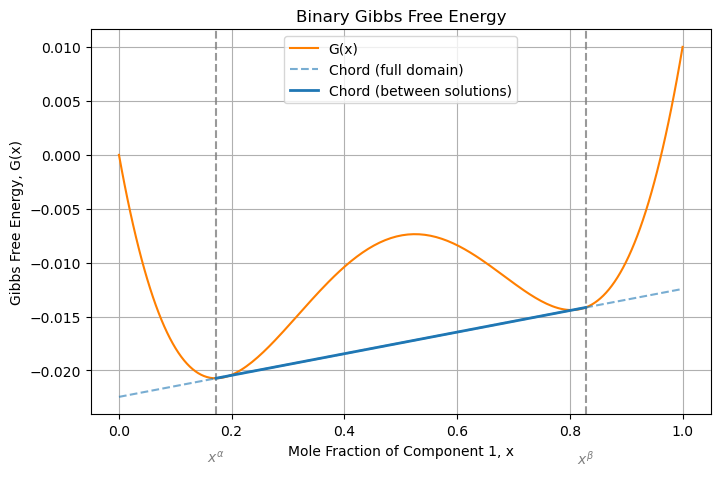

In [29]:
plot_g_binary(f, eq_points=x_sol)

# New implementation using shgo loop minimization plus plots 

In [39]:
import numpy as np
from scipy.optimize import linprog

###############################################################################
# 1) LOWER BOUND EVALUATION
###############################################################################
def lbd(x, g_func, Lambda, Z_0):
    """
    Evaluate the lower-bounding function for the dual problem.

    Parameters
    ----------
    x : 1D array_like
        Current composition (length n). Must satisfy sum(x) = 1, x >= 0.
    g_func : callable
        A Gibbs free energy function G(x) that returns a scalar.
    Lambda : 1D array_like
        Lagrange multipliers (length n) from the upper bounding step.
    Z_0 : 1D array_like
        Feed composition (length n) with sum(Z_0) = 1.

    Returns
    -------
    float
        Value of G(x) + Lambda dot (Z_0 - x).
    """
    return g_func(x) + np.dot(Lambda, (Z_0 - x))


###############################################################################
# 2) UPPER BOUND CONSTRUCTION
###############################################################################
def ubd(X_D, Z_0, g_func, n):
    """
    Builds the linear program (LP) used to find the new dual hyperplane.

    This sets up a max-η subject to:
       η <= G(x_d) + Lambda^T (Z_0 - x_d)   for all x_d in X_D
       η <= G(Z_0)                         (optional global bound)
    and Lambda is unconstrained except possibly by numeric bounds
    to keep the LP well-defined.

    Parameters
    ----------
    X_D : list of 1D array_like
        List of compositions (length n each). These points have been found
        so far in the dual iterations.
    Z_0 : 1D array_like
        Feed composition (length n).
    g_func : callable
        Gibbs free energy function G(x).
    n : int
        Number of components (length of x).

    Returns
    -------
    c : ndarray
        Coefficients of the linear objective for `linprog`.
    A_ub : ndarray
        Matrix of inequality constraints for `linprog`.
    b_ub : ndarray
        RHS vector of inequality constraints for `linprog`.
    bounds : list of tuples
        Bounds for the decision variables [Lambda_1, ..., Lambda_n, eta].
        Each bound is a tuple (lb, ub). Usually (-np.inf, np.inf) for Lambdas.
    """
    # We'll store variables in this order: [Lambda_1, ..., Lambda_n, eta]
    # So the dimension is n + 1 total decision variables.
    # We want to maximize eta => in standard linprog form, we "minimize -eta".
    c = np.zeros(n + 1)
    c[-1] = -1.0  # Minimizing -eta is same as maximizing eta

    # Build constraints:
    # For each x_d in X_D:  eta <= G(x_d) + Lambda^T (Z_0 - x_d)
    # =>  -eta + Lambda^T (Z_0 - x_d) <= G(x_d)
    # =>  (Z_0 - x_d) for Lambda part, -1 for eta part.

    num_points = len(X_D)
    A_ub = np.zeros((num_points + 1, n + 1))
    b_ub = np.zeros(num_points + 1)

    # Optional global constraint: eta <= G(Z_0)
    G_feed = g_func(Z_0)  # We can use the feed composition's own G
    A_ub[num_points, -1] = -1.0
    b_ub[num_points] = G_feed

    # Constraints from each x_d
    for k, x_d in enumerate(X_D):
        # Coeff for Lambda part is (Z_0 - x_d)
        for i in range(n):
            A_ub[k, i] = Z_0[i] - x_d[i]
        # Coeff for eta part is -1
        A_ub[k, -1] = -1.0
        # RHS is G(x_d)
        b_ub[k] = g_func(x_d)

    # Bounds on Lambda_i can be unbounded
    # Bounds on eta can also be unbounded above (in principle).
    # But typically you might impose practical bounds on Lambdas to help numerical stability.
    # For this example, let's just leave them unbounded:
    bounds = [(-1.0e9, 1.0e9)]*(n+1)

    return c, A_ub, b_ub, bounds


###############################################################################
# 3) MAIN DUAL-BASED SOLVER
###############################################################################
def solve_dual_equilibrium(g_func, Z_0, 
                           ph_n=2,
                           n=10,
                           tol=1e-9,
                           max_iter=20,
                           global_minimizer=None):
    """
    Solves for a dual hyperplane that proves the system is unstable
    at Z_0 (or identifies that single-phase is stable if no feasible
    cutting plane can be found). The user must supply a global minimizer
    for the LBD step.

    Parameters
    ----------
    g_func : callable
        A function g_func(x) -> float that returns the Gibbs free energy.
        x is an array of length n with sum(x) = 1, x[i] >= 0.
    Z_0 : 1D array_like
        Feed composition of length n, sum(Z_0)=1.
    ph_n : int
        Number of components in the mixture.
    n : int, optional
        Number of sampling points used by shgo in the global step.    
    tol : float, optional
        Convergence tolerance. If UBD - LBD < tol, iteration stops.
    max_iter : int, optional
        Maximum number of dual iterations.

    Returns
    -------
    X_sol : 1D array
        Composition that yields the best cutting plane in the final iteration.
    Lambda_sol : 1D array
        Final Lagrange multipliers for the dual tangent plane.
    history : dict
        Diagnostic info about iteration progress.

    Notes
    -----
    - The code is purely functional, with no references to temperature or pressure.
    - Phase detection is replaced by direct bounding-plane construction.
    - If single-phase is indeed stable, you might find that the linear program
      basically saturates at the feed composition with no beneficial cut,
      i.e. LBD and UBD remain near G(Z_0).

    Example usage:

        X_sol, Lambda_sol, hist = solve_dual_equilibrium(
            g_nrtl, [0.5, 0.5], ph_n=2
        )
    """
    Z_0 = np.array(Z_0, dtype=float)
    assert abs(Z_0.sum() - 1.0) < 1e-12, "Z_0 must sum to 1"
    assert all(Z_0 >= 0), "All feed composition entries must be >= 0"

    # For convenience, define a trivial initial set X_D with
    # "corner" points to help bound multipliers:
    # e.g. slightly perturbed pure corners & feed itself, etc.
    # We'll also store the feed composition in X_D so we get the
    # global bound from G(Z_0).
    X_D = []
    eps = 1e-8

    # Add points that are "almost pure" in each component
    for i in range(ph_n):
        x_pure = np.zeros(n, dtype=float)
        x_pure[i] = 1.0
        X_D.append(0.9999999 * x_pure + 1e-8)  # small shift
        # Also a slightly "near-zero" composition:
        x_low = np.full(n, 1.0/(n*1.0))
        x_low[i] = eps
        x_low[(i+1) % n] = 1 - eps - (n-1)*(1/(n*1.0))
        X_D.append(x_low)

    # Finally add the feed composition itself
    X_D.append(Z_0)

    # Evaluate initial LBD & UBD
    LBD = -1e15  # something like negative infinity
    UBD = g_func(Z_0)  # trivial upper bound from feed

    history = {
        'iterations': [],
        'UBD': [],
        'LBD': [],
        'Lambda': [],
        'X_star': []
    }

    def default_global_minimizer(obj_func, n, args, x_bounds):
        """
        Placeholder local/naive approach for demonstration:
        random sampling + local check. Not truly global.
        """
        best_val = 1e15
        best_x = None
        n_samples = 200

        for _ in range(n_samples):
            # sample random composition x, sum=1
            xr = np.random.rand(n)
            xr = xr / xr.sum()
            val = obj_func(xr, *args)
            if val < best_val:
                best_val = val
                best_x = xr

        return best_x, best_val

    if global_minimizer is None:
        global_minimizer = default_global_minimizer

    for iteration in range(1, max_iter+1):

        # Step 1: Solve UBD as an LP
        c, A_ub, b_ub, bounds = ubd(X_D, Z_0, g_func, ph_n)
        lp_res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
        if not lp_res.success:
            # If LP fails, we stop. Possibly single-phase stable or numeric issues
            print("LP failed at iteration", iteration, lp_res.message)
            break

        # Decision variables are [Lambda_1..Lambda_n, eta]
        x_lp = lp_res.x
        Lambda_sol = x_lp[:ph_n].copy()
        eta_sol = x_lp[-1]

        # Because c[-1] = -1, we minimized -eta => final objective is -eta_sol
        # => UBD =  -lp_res.fun
        cur_UBD = -lp_res.fun

        # Step 2: Solve LBD subproblem with shgo
        #   lbd(x) = G(x) + sum( Lambda_sol * (Z_0 - x) )
        def lbd_obj(x, g_func, Lambda, Z_0):
            return lbd(x, g_func, Lambda, Z_0)
        
        # Define the simplex bounds: each x[i] in [0,1]
        bounds = [(0, 1)] * ph_n
        
        # Define the equality constraint: sum(x) = 1
        # If ph_n=2, that's sum(x[0]+x[1])=1, etc.
        # NonlinearConstraint or the older dict-based format:
        con = {'type':'eq',
               'fun': lambda x: np.sum(x) - 1.0}
        
        # Now call shgo, ensuring we pass `constraints=con`
        res = shgo(
            lbd_obj,
            bounds=bounds,
            args=(g_func, Lambda_sol, Z_0),
            constraints=con,   # <--- critical
            n=n
        )
        
        if not res.success:
            print("shgo could not find a feasible solution:", res.message)
            break
        
        print(f'res = {res}')
        x_star, val_star = res.x, res.fun
        cur_LBD = val_star

        # Update iteration tracking
        history['iterations'].append(iteration)
        history['UBD'].append(cur_UBD)
        history['LBD'].append(cur_LBD)
        history['Lambda'].append(Lambda_sol)
        history['X_star'].append(x_star)

        # If improvement was found, add x_star to X_D
        X_D.append(x_star)

        # Check termination
        if abs(cur_UBD - cur_LBD) < tol:
            print(f"Converged at iteration {iteration} with UBD={cur_UBD:.6g}, "
                  f"LBD={cur_LBD:.6g}")
            break

        # Prepare for next iteration
        LBD = cur_LBD
        UBD = cur_UBD

    # Return the final results
    return x_star, Lambda_sol, history



In [40]:
def g(x):
    return g_nrtl(x, p)

x_star, Lambda_sol, history = solve_dual_equilibrium(g, [0.5, 0.5], 2,
                           tol=1e-9,
                           max_iter=20,
                           global_minimizer=None)

res =  message: Optimization terminated successfully.
 success: True
     fun: -0.033334572341620544
    funl: [-3.333e-02]
       x: [ 9.431e-01  5.694e-02]
      xl: [[ 9.431e-01  5.694e-02]]
     nit: 1
    nfev: 55
   nlfev: 45
   nljev: 13
   nlhev: 0
res =  message: Optimization terminated successfully.
 success: True
     fun: -0.033334572341620544
    funl: [-3.333e-02]
       x: [ 9.431e-01  5.694e-02]
      xl: [[ 9.431e-01  5.694e-02]]
     nit: 1
    nfev: 55
   nlfev: 45
   nljev: 13
   nlhev: 0
res =  message: Optimization terminated successfully.
 success: True
     fun: -0.033334572341620544
    funl: [-3.333e-02]
       x: [ 9.431e-01  5.694e-02]
      xl: [[ 9.431e-01  5.694e-02]]
     nit: 1
    nfev: 55
   nlfev: 45
   nljev: 13
   nlhev: 0
res =  message: Optimization terminated successfully.
 success: True
     fun: -0.033334572341620544
    funl: [-3.333e-02]
       x: [ 9.431e-01  5.694e-02]
      xl: [[ 9.431e-01  5.694e-02]]
     nit: 1
    nfev: 55
   nlfev: 

/tmp/ipykernel_22915/812652699.py:45: RuntimeWarning: divide by zero encountered in log
  g_mix = (x1 * np.log(x1)
/tmp/ipykernel_22915/812652699.py:45: RuntimeWarning: invalid value encountered in scalar multiply
  g_mix = (x1 * np.log(x1)
/tmp/ipykernel_22915/812652699.py:46: RuntimeWarning: divide by zero encountered in log
  + x2 * np.log(x2)
/tmp/ipykernel_22915/812652699.py:46: RuntimeWarning: invalid value encountered in scalar multiply
  + x2 * np.log(x2)
/tmp/ipykernel_22915/812652699.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  * ((t_12 * np.exp(-a_12 * t_12)) / (x2 + x1 * np.exp(-a_12 * t_12))
/tmp/ipykernel_22915/812652699.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  + (t_21 * np.exp(-a_21 * t_21)) / (x1 + x2 * np.exp(-a_21 * t_21))))
/tmp/ipykernel_22915/812652699.py:47: RuntimeWarning: invalid value encountered in scalar multiply
  + x1 * x2


In [47]:
# Two-component feed, 50-50
Z0 = [0.5, 0.5]
# We call solve_dual_equilibrium with a user-chosen global_minimizer (or let the default run).
x_sol, Lambda_sol, hist = solve_dual_equilibrium(
    g_func=f_2d,
    Z_0=Z0,
    n=3,
    tol=1e-20,
    max_iter=100
)

print("----- Dual solution results -----")
print("x_sol =", x_sol)
print("Lambda_sol =", Lambda_sol)
print("UBD history =", hist['UBD'])
print("LBD history =", hist['LBD'])

print(f'New x_sol = {x_sol} vs. old [0.17524159 0.82475841] vs. shgo n=3, max_iter=10,tol=1e-7 [0.17194406 0.82805594]')

res =  message: Optimization terminated successfully.
 success: True
     fun: -0.020722484335026325
    funl: [-2.072e-02]
       x: [ 1.719e-01  8.281e-01]
      xl: [[ 1.719e-01  8.281e-01]]
     nit: 1
    nfev: 28
   nlfev: 25
   nljev: 8
   nlhev: 0
res =  message: Optimization terminated successfully.
 success: True
     fun: -0.020722484335026325
    funl: [-2.072e-02]
       x: [ 1.719e-01  8.281e-01]
      xl: [[ 1.719e-01  8.281e-01]]
     nit: 1
    nfev: 28
   nlfev: 25
   nljev: 8
   nlhev: 0
res =  message: Optimization terminated successfully.
 success: True
     fun: -0.020722484335026325
    funl: [-2.072e-02]
       x: [ 1.719e-01  8.281e-01]
      xl: [[ 1.719e-01  8.281e-01]]
     nit: 1
    nfev: 28
   nlfev: 25
   nljev: 8
   nlhev: 0
res =  message: Optimization terminated successfully.
 success: True
     fun: -0.020722484335026325
    funl: [-2.072e-02]
       x: [ 1.719e-01  8.281e-01]
      xl: [[ 1.719e-01  8.281e-01]]
     nit: 1
    nfev: 28
   nlfev: 25


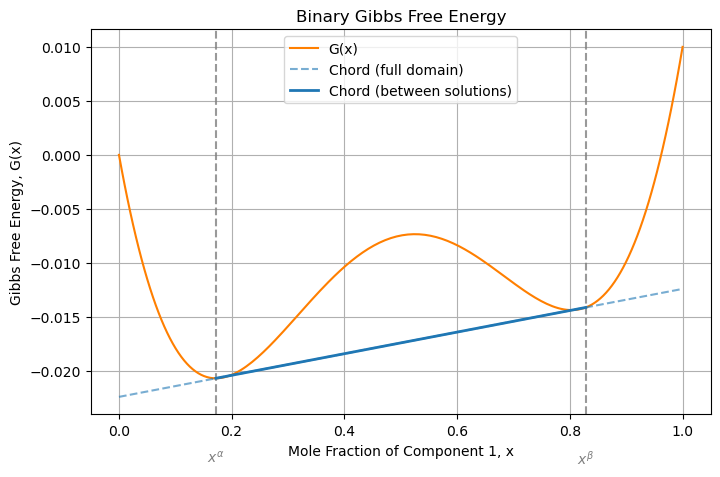

In [43]:
plot_g_binary(f, eq_points=x_sol)